In [1]:
"""
Created Using Python 3.6
"""
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
def load_soliton_data(filename):
    """
    helper function to load soliton data from @filename.mat file
    """
    from scipy.io import loadmat
    data = loadmat(filename)
    A0 = data["A0"]
    A0_error = data["A0_error"]
    U0 = data["U0"]
    A = data["Amat"]
    t = data["t_vec"].reshape(-1,1)
    z = data["z_vec"].reshape(-1,1)
    return t, z, A, U0, A0, A0_error

In [3]:
t, z, A, U0, A0, A0_error = load_soliton_data("data/expData07.mat")

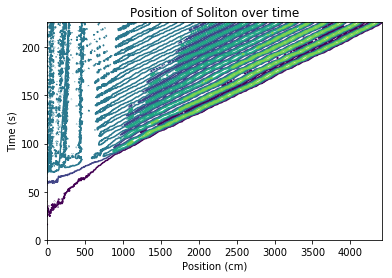

In [4]:
"""
Make a contour plot of a soliton's A matrix
"""
plt.contour(A)
plt.title("Position of Soliton over time")
plt.xlabel("Position (cm)")
plt.ylabel("Time (s)")
plt.savefig("contour.png")

In [5]:
def getSpeed(A, z, t):
    """
    Experimentally determine the speed of the 
    soliton from it's amplitude matrix A
    """
    from scipy.stats import linregress
    # First we get a slice of A that looks good, we determined the 
    # middle third of the matrix to work
    m = A.shape[1]
    a = np.argmax(A[:, m//3:2*m//3], axis=0)
    t_ = []
    z_ = []
    # Get the maximum value and tabulate it's space and time value
    for i, a_ in enumerate(a):
        idx = i + m//3
        z_.append(idx)
        t_.append(a_)
    z_ = z[z_].flatten()
    t_ = t[t_].flatten()
    # Use scipy to fit a line to the maximums,
    # and then return the slope of the line
    slope = linregress(t_,z_)
    return slope[0]

In [6]:
def speedAmplitudeRelation(A0):
    """
    Return dimensionless speed from theoretical S-A relation
    """
    return ( A0**2 - 1 - 2*A0**2 * np.log(A0) ) / (2*A0 - 1 - A0**2)

In [7]:
A_ = []
C_ = []
C2_ = []
for filename in os.listdir("data"):
    if filename.endswith(".mat"):
        t, z, A, U0, A0, A0_error = load_soliton_data("data/"+filename)
        A_.append(A0)
        C_.append(getSpeed(A, z, t))
        C2_.append(speedAmplitudeRelation(A0)*U0)

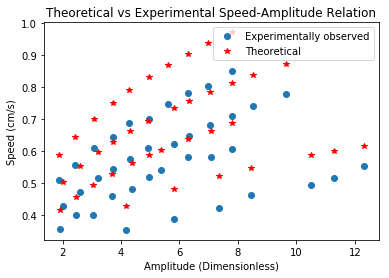

In [8]:
A_ = np.reshape(A_, -1, 1)
C2_ = np.reshape(C2_, -1, 1)
plt.plot(A_, C_, "o", label = "Experimentally observed")
plt.plot(A_, C2_, "r*", label="Theoretical")
plt.xlabel("Amplitude (Dimensionless)")
plt.ylabel("Speed (cm/s)")
plt.title("Theoretical vs Experimental Speed-Amplitude Relation")
plt.legend()
plt.savefig("sa_relation.png")

In [9]:
def g(f, c):
    # g(f,c) determined from PDE, done in steps for numerical stability
    sq = (c-1)/(c * f**2) + (c + 1)/c - 2/f - 2 * np.log(f)/c
    # Make sure we don't go into the complex plane,
    # we don't want to run into Mark Ablowitz
    if sq < 0:
        sq = 0
    return f*np.sqrt(sq)

In [10]:
def eulers(zeta_0, g, a, delta, n=100):
    """
    Perform Euler's method to generate the numerical solution of 
    zeta(f), a soliton with amplitude @a
    """
    
    # Determine the f-domain
    f = np.linspace(1 + delta, a, num=n)
    
    # Allocate space for zeta
    Z = np.zeros(shape=f.shape)
    Z[0] = zeta_0
    
    # Determine stepsize
    del_f = f[1]-f[0]
    
    # Get theoretical speed
    c = speedAmplitudeRelation(a)
    
    # Integrate
    for i in range(1, n):
        # Catch ourselves if we accidentally hit the singularity
        # at f = a
        if g(f[i-1], c) == 0:
            return Z, f
        else:
            Z[i] = Z[i-1] + del_f/g(f[i-1],c)
    return Z, f

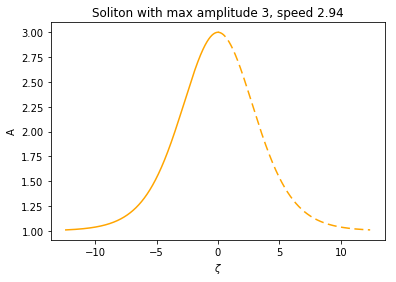

In [16]:
def plot_soliton(a, filename=None, label=None, color="orange", title=True):
    """
    Plots numerical solution of soliton with amplitude @a
    other params:
    @filename is where to save the figure
    @label is the legend key
    @color of plot, default orange
    @title determines if an auto-generated title should be used
    """
    
    # First get our numerical solution
    Z, F = eulers(-100, g, a, 0.01, n=50000)
    
    # Center over the zeta-axis
    Z = Z - Z[-1]
    
    # Plot with optional label and title
    if label:
        plt.plot(Z, F, c=color, label=label)
        plt.legend()
    else:
        plt.plot(Z, F, c=color)
    plt.plot(-Z[::-1], F[::-1], c=color, dashes=[6,3])
    plt.xlabel("$\zeta$")
    plt.ylabel("A")
    if title:
        plt.title("Soliton with max amplitude {}, speed {:.2f}".format(a, speedAmplitudeRelation(a)))

    # Save figure
    if filename:
        plt.savefig(filename)

plot_soliton(3, filename="numerical.png")

In [12]:
t, z, A, U0, A0, A0_error = load_soliton_data("data/expData07.mat")

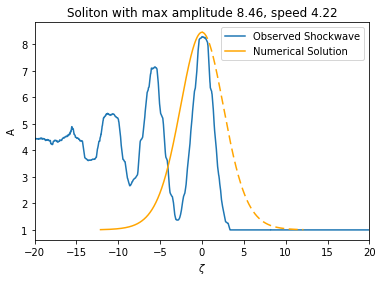

In [13]:
slice = A[len(A)//2]
max = np.argmax(slice)
z_shift = z - z[max]
plt.plot(z_shift,slice, label="Observed Shockwave")
plt.xlim(-20, 20)
plot_soliton(A0[0][0], label="Numerical Solution")
plt.savefig("compare.png")

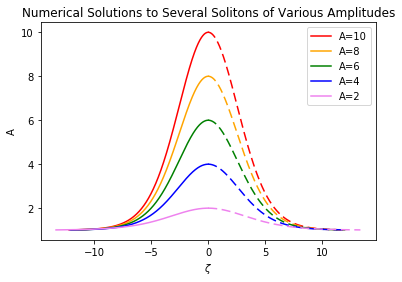

In [14]:
amps = [10, 8, 6, 4, 2]
colors = ["red", "orange", "green", "blue", "violet"]
labels = [f"A={a}" for a in amps]
for i in range(len(amps)):
    plot_soliton(amps[i], label=labels[i], color=colors[i], title=False)

plt.title("Numerical Solutions to Several Solitons of Various Amplitudes")
plt.savefig("multiple.png")

In [15]:
# Forgot to get the mean of the soliton speeds
np.mean(C_)

0.5729283955984424